In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob
from scipy.stats import binned_statistic

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 5000)
pd.set_option("display.max_colwidth", 5000)
plt.style.use("science")

In [2]:
# Load artifacts
def get_dfs(dataset_name):
    df = pd.read_pickle(
        f"/Users/kbibas/datasets/fbt_research/data/final/{dataset_name}_sets.pkl"
    )
    pop_pred_cat_aware = pd.read_pickle(
        f"/Users/kbibas/code/fbt_research/outputs/analysis_reults/pop_category_aware_pred.pkl_{dataset_name}.pkl"
    )
    dcf_pred = pd.read_pickle(
        glob(
            f"/Users/kbibas/code/fbt_research/outputs/analysis_reults/train_dcf*{dataset_name}_*.pkl"
        )[0]
    )
    pcomp_pred = pd.read_pickle(
        glob(
            
            f"/Users/kbibas/code/fbt_research/outputs/analysis_reults/train_addone_pcomp_{dataset_name}_*.pkl"
        )[0]
    )  
    triplet_pred = pd.read_pickle(
        glob(
            f"/Users/kbibas/code/fbt_research/outputs/analysis_reults/train_*triplet_{dataset_name}_*.pkl"
        )[0]
    )

    gan_pred = pd.read_pickle(
        glob(
            f"/Users/kbibas/code/fbt_research/outputs/analysis_reults/train_{dataset_name}_*.pkl"
        )[0]
    )
    
    
    return df, pop_pred_cat_aware,dcf_pred,pcomp_pred , triplet_pred, gan_pred

In [3]:
def create_plot_df(df, pred_df):
    target_count = (
        df.groupby(["category_int_target"])["asin_target"]
        .nunique()
        .reset_index()
        .rename(columns={"asin_target": "count"})
    )

    # Training set size
    training_set_count = (
        df[df["set_name"] == "train"]
        .groupby(["category_int_src", "category_int_target"])
        .size()
        .reset_index()
    )
    training_set_count = training_set_count.rename(columns={0: "train_size"})

    # Prepare test set
    test_df = df[df["set_name"] == "test"][
        ["asin_src", "category_int_src", "category_int_target"]
    ]
    test_df = pd.merge(
        test_df,
        pred_df,
        left_on=["asin_src", "category_int_target"],
        right_on=["asins", "category_pos_test"],
        how="inner",
    )
    test_df = pd.merge(
        test_df,
        target_count,
        left_on=["category_int_target"],
        right_on=["category_int_target"],
        how="left",
    )

    # Merge test set with training set count
    merge_df = pd.merge(
        test_df,
        training_set_count,
        left_on=["category_int_src", "category_int_target"],
        right_on=["category_int_src", "category_int_target"],
        how="left",
    )
    # merge_df = merge_df.fillna(0)
    merge_df = merge_df.dropna()

    merge_df["sparsity"] = merge_df["train_size"]  / merge_df["count"]
    print(len(merge_df))
    merge_df = merge_df.drop_duplicates()
    print(len(merge_df))

    rolling_size = 330
    ndcg_mean = (
        merge_df.groupby("sparsity")["ndcg"]
        .mean()
        .sort_index()
        .rolling(rolling_size)
        .mean()
    )
    ndcg_std = (
        merge_df.groupby("sparsity")["ndcg"]
        .mean()
        .sort_index()
        .rolling(rolling_size)
        .std()
    )

    low = ndcg_mean + 1.960 * ndcg_std / np.sqrt(rolling_size)
    high = ndcg_mean - 1.960 * ndcg_std / np.sqrt(rolling_size)
        
    merge_df["sparsity"] = merge_df["train_size"]
    print(len(merge_df))
    merge_df = merge_df.drop_duplicates()
    print(len(merge_df))
    

    return ndcg_mean, low, high

Clothing_Shoes_and_Jewelry
11714
6025
6025
6025
11714
6025
6025
6025
11714
6025
6025
6025
11714
6025
6025
6025
11714
6025
6025
6025
Toys_and_Games
25849
12080
12080
12080
25849
12080
12080
12080
25849
12080
12080
12080
25849
12080
12080
12080
25849
12080
12080
12080
Home_and_Kitchen
36532
19335
19335
19335
36532
19335
19335
19335
36532
19335
19335
19335
36532
19335
19335
19335
36532
19335
19335
19335


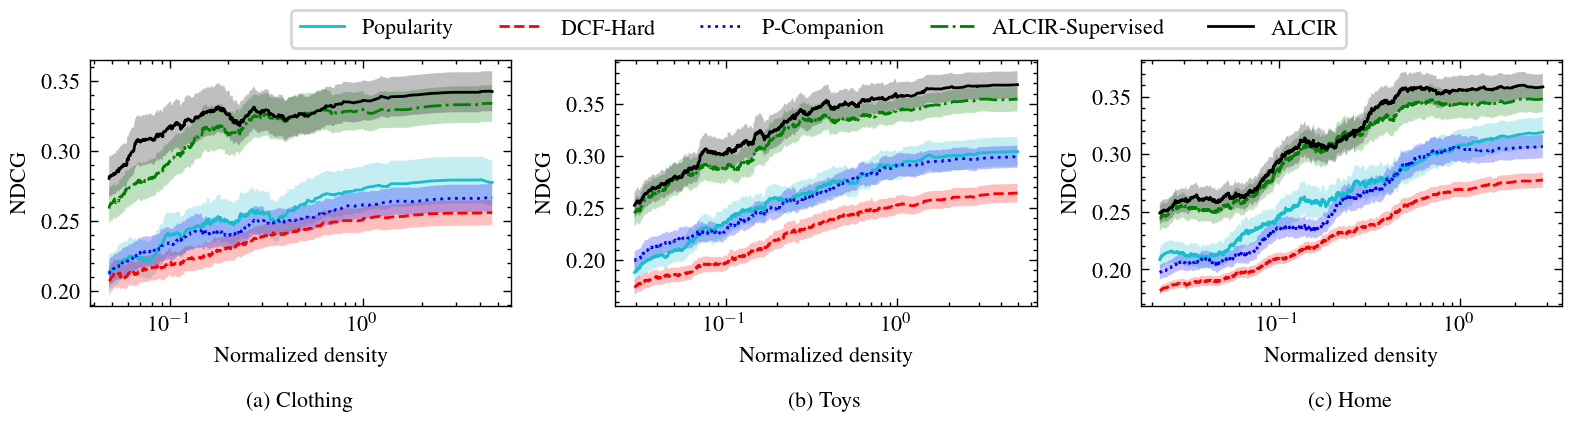

In [4]:
plt.style.use(["science", "ieee"])
fig, axs = plt.subplots(1, 3, dpi=200, figsize=(8, 2))

dataset_names = ["Clothing_Shoes_and_Jewelry","Toys_and_Games","Home_and_Kitchen"]
xlabel_texts = ['(a) Clothing', '(b) Toys', '(c) Home']
for ax, dataset_name,xlabel_text in zip(axs, dataset_names,xlabel_texts):
    print(dataset_name)
    df, pop_pred_cat_aware, dcf_pred,pcomp_pred, triplet_pred, gan_pred = get_dfs(dataset_name)
    pop_plot_pred, low1, high1 = create_plot_df(df, pop_pred_cat_aware)
    dcf_plot_pred, low2, high2 = create_plot_df(df, dcf_pred)
    pcomp_plot_pred, low3, high3 = create_plot_df(df, pcomp_pred)
    triplet_plot_pred, low4, high4 = create_plot_df(df, triplet_pred)
    gan_plot_pred, low5, high5 = create_plot_df(df, gan_pred)

    ax.plot(pop_plot_pred, label="Popularity", color='tab:cyan')
    ax.fill_between(low1.index, low1.values, high1.values, facecolor="tab:cyan", alpha=0.25)
    ax.plot(dcf_plot_pred, label="DCF-Hard")
    ax.fill_between(low2.index, low2.values, high2.values, facecolor="C1", alpha=0.25)
    ax.plot(pcomp_plot_pred, label="P-Companion")
    ax.fill_between(low3.index, low3.values, high3.values, facecolor="C2", alpha=0.25)
    ax.plot(triplet_plot_pred, label="ALCIR-Supervised")
    ax.fill_between(low4.index, low4.values, high4.values, facecolor="C3", alpha=0.25)
    ax.plot(gan_plot_pred, label="ALCIR")
    ax.fill_between(low5.index, low5.values, high5.values, facecolor="C4", alpha=0.25)
    ax.set_ylabel("NDCG")
    ax.set_xlabel(f"Normalized density\n\n{xlabel_text}")
    ax.set_xscale('log')
    

plt.tight_layout()
axs[0].legend(bbox_to_anchor=(0.45, 1.25),loc='upper left', ncol=5,frameon=True)
plt.savefig(f"ndcg_vs_denisty.pdf")
plt.show()

Clothing_Shoes_and_Jewelry
11714
6025
11714
6025
11714
6025
11714
6025
11714
6025
Toys_and_Games
25849
12080
25849
12080
25849
12080
25849
12080
25849
12080
Home_and_Kitchen
36532
19335
36532
19335
36532
19335
36532
19335
36532
19335


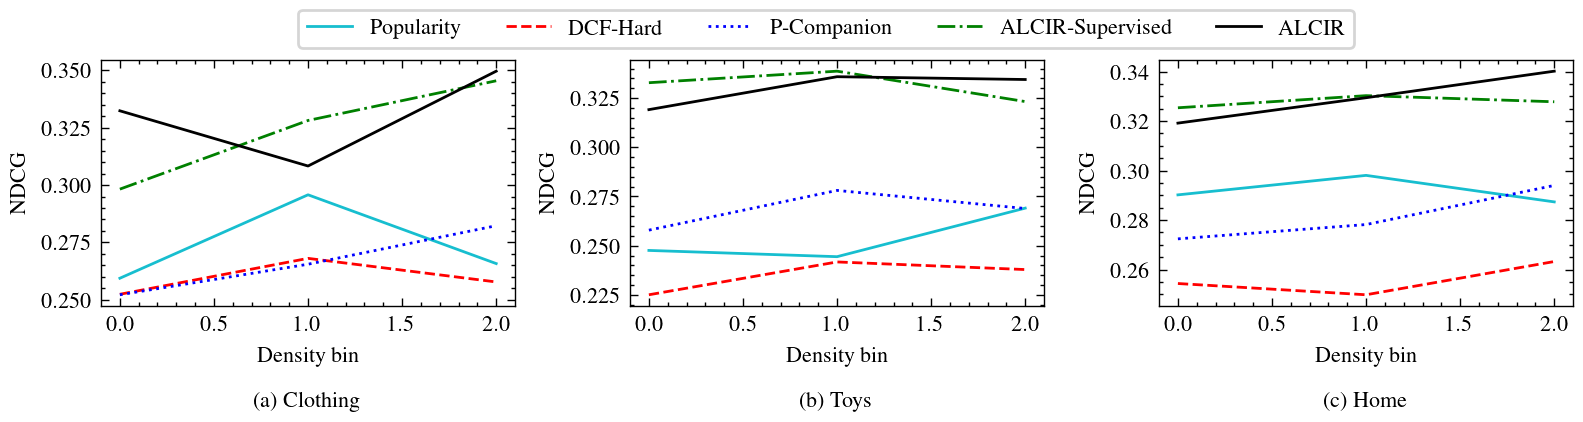

In [5]:
def create_plot_df(df, pred_df):
    target_count = (
        df.groupby(["category_int_target"])["asin_target"]
        .nunique()
        .reset_index()
        .rename(columns={"asin_target": "count"})
    )

    # Training set size
    training_set_count = (
        df[df["set_name"] == "train"]
        .groupby(["category_int_src", "category_int_target"])
        .size()
        .reset_index()
    )
    training_set_count = training_set_count.rename(columns={0: "train_size"})

    # Prepare test set
    test_df = df[df["set_name"] == "test"][
        ["asin_src", "category_int_src", "category_int_target"]
    ]
    test_df = pd.merge(
        test_df,
        pred_df,
        left_on=["asin_src", "category_int_target"],
        right_on=["asins", "category_pos_test"],
        how="inner",
    )
    test_df = pd.merge(
        test_df,
        target_count,
        left_on=["category_int_target"],
        right_on=["category_int_target"],
        how="left",
    )

    # Merge test set with training set count
    merge_df = pd.merge(
        test_df,
        training_set_count,
        left_on=["category_int_src", "category_int_target"],
        right_on=["category_int_src", "category_int_target"],
        how="left",
    )
    
    # merge_df = merge_df.fillna(0)
    merge_df = merge_df.dropna()
    print(len(merge_df))
    merge_df = merge_df.drop_duplicates()
    print(len(merge_df))
    
    statistic_list = []
    num_cat = []
    for i,df_i in merge_df.groupby(['category_int_target']):
        category_int_src_num_items_list,mean_ndcg_list = [], [] 
        for ij, df_ij in df_i.groupby(['category_int_src']):
            mean_ndcg = df_ij.ndcg.mean()
            category_int_src_num_items = len(df_ij)
            category_int_src_num_items_list.append(category_int_src_num_items)
            mean_ndcg_list.append(mean_ndcg)

        num_bins = 3
        x,y =np.array(category_int_src_num_items_list),np.array(mean_ndcg_list)
        out,bins = pd.qcut(x,num_bins,retbins=True,duplicates='drop')
        statistic,bin_edges,bin_num = binned_statistic(x,y,bins=bins)
        
        if len(statistic) == num_bins:
            statistic_list.append(statistic)
        num_cat.append(len(statistic))
    mean_ndcg = np.nanmean(np.vstack(statistic_list),axis=0)
    return mean_ndcg

plt.style.use(["science", "ieee"])
fig, axs = plt.subplots(1, 3, dpi=200, figsize=(8, 2))

dataset_names = ["Clothing_Shoes_and_Jewelry","Toys_and_Games","Home_and_Kitchen"]
xlabel_texts = ['(a) Clothing', '(b) Toys', '(c) Home']
for ax, dataset_name,xlabel_text in zip(axs, dataset_names,xlabel_texts):
    print(dataset_name)
    df, pop_pred_cat_aware, dcf_pred,pcomp_pred, triplet_pred, gan_pred = get_dfs(dataset_name)
    pop_plot_pred = create_plot_df(df, pop_pred_cat_aware)
    dcf_plot_pred= create_plot_df(df, dcf_pred)
    pcomp_plot_pred = create_plot_df(df, pcomp_pred)
    triplet_plot_pred = create_plot_df(df, triplet_pred)
    gan_plot_pred = create_plot_df(df, gan_pred)
    
    ax.plot(pop_plot_pred, label="Popularity", color='tab:cyan')
    ax.plot(dcf_plot_pred, label="DCF-Hard")
    ax.plot(pcomp_plot_pred, label="P-Companion")
    ax.plot(triplet_plot_pred, label="ALCIR-Supervised")
    ax.plot(gan_plot_pred, label="ALCIR")

    ax.set_ylabel("NDCG")
    ax.set_xlabel(f"Density bin\n\n{xlabel_text}")
    # ax.set_xscale('log')
    

plt.tight_layout()
axs[0].legend(bbox_to_anchor=(0.45, 1.25),loc='upper left', ncol=5,frameon=True)
plt.savefig(f"ndcg_vs_target_denisty_bins.pdf")
plt.show()

Clothing_Shoes_and_Jewelry
11714
6025
11714
6025
11714
6025
11714
6025
11714
6025
Toys_and_Games
25849
12080
25849
12080
25849
12080
25849
12080
25849
12080
Home_and_Kitchen
36532
19335
36532
19335
36532
19335
36532
19335
36532
19335


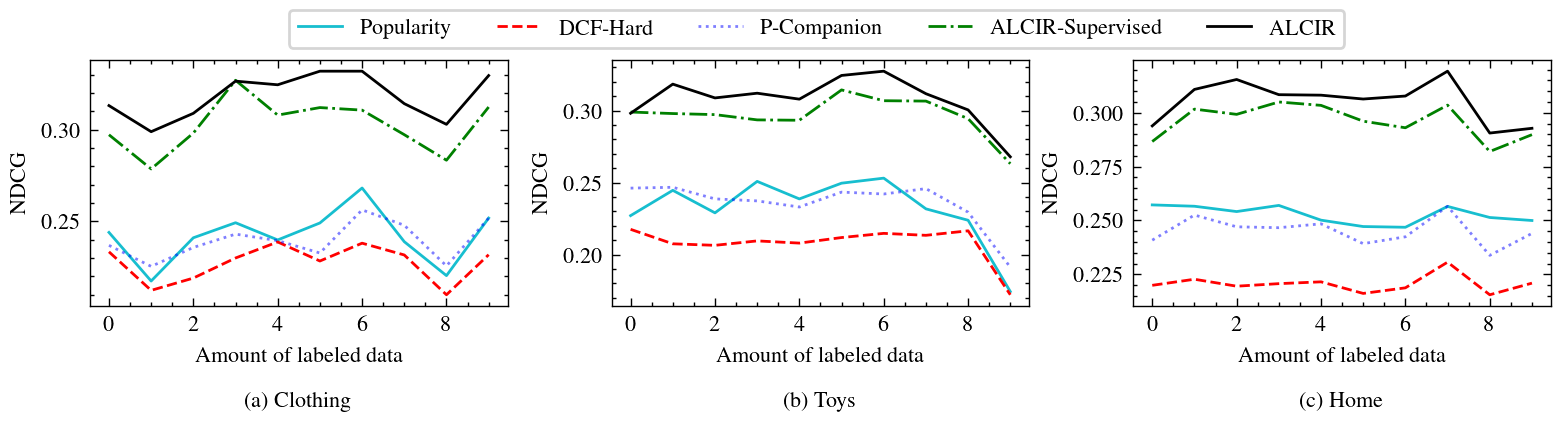

In [9]:
def create_plot_df(df, pred_df):
    target_count = (
        df.groupby(["category_int_target"])["asin_target"]
        .nunique()
        .reset_index()
        .rename(columns={"asin_target": "count"})
    )

    # Training set size
    training_set_count = (
        df[df["set_name"] == "train"]
        .groupby(["category_int_src", "category_int_target"])
        .size()
        .reset_index()
    )
    training_set_count = training_set_count.rename(columns={0: "train_size"})

    # Prepare test set
    test_df = df[df["set_name"] == "test"][
        ["asin_src", "category_int_src", "category_int_target"]
    ]
    test_df = pd.merge(
        test_df,
        pred_df,
        left_on=["asin_src", "category_int_target"],
        right_on=["asins", "category_pos_test"],
        how="inner",
    )
    test_df = pd.merge(
        test_df,
        target_count,
        left_on=["category_int_target"],
        right_on=["category_int_target"],
        how="left",
    )

    # Merge test set with training set count
    merge_df = pd.merge(
        test_df,
        training_set_count,
        left_on=["category_int_src", "category_int_target"],
        right_on=["category_int_src", "category_int_target"],
        how="left",
    )
    # merge_df = merge_df.fillna(0)
    merge_df = merge_df.dropna()
    print(len(merge_df))
    merge_df = merge_df.drop_duplicates()
    print(len(merge_df))
    

    return merge_df

plt.style.use(["science", "ieee"])
fig, axs = plt.subplots(1, 3, dpi=200, figsize=(8, 2))

dataset_names = ["Clothing_Shoes_and_Jewelry","Toys_and_Games","Home_and_Kitchen"]
xlabel_texts = ['(a) Clothing', '(b) Toys', '(c) Home']
for ax, dataset_name,xlabel_text in zip(axs, dataset_names,xlabel_texts):
    print(dataset_name)
    df, pop_pred_cat_aware, dcf_pred,pcomp_pred, triplet_pred, gan_pred = get_dfs(dataset_name)
    pop_plot_pred = create_plot_df(df, pop_pred_cat_aware)
    dcf_plot_pred= create_plot_df(df, dcf_pred)
    pcomp_plot_pred = create_plot_df(df, pcomp_pred)
    triplet_plot_pred = create_plot_df(df, triplet_pred)
    gan_plot_pred = create_plot_df(df, gan_pred)
    
    x, y = pop_plot_pred['train_size'],pop_plot_pred['ndcg']
    out,bins = pd.qcut(x,10,retbins=True)
    statistic,bin_edges,bin_num = binned_statistic(x,y,bins=bins)
    ax.plot(np.arange(10),statistic, label="Popularity", color='tab:cyan')
    
    x, y = dcf_plot_pred['train_size'],dcf_plot_pred['ndcg']
    out,bins = pd.qcut(x,10,retbins=True)
    statistic,bin_edges,bin_num = binned_statistic(x,y,bins=bins)
    ax.plot(np.arange(10),statistic, label="DCF-Hard")
    
    x, y = pcomp_plot_pred['train_size'],pcomp_plot_pred['ndcg']
    out,bins = pd.qcut(x,10,retbins=True)
    statistic,bin_edges,bin_num = binned_statistic(x,y,bins=bins)
    ax.plot(np.arange(10),statistic, label="P-Companion", alpha=0.5)
    
    x, y = triplet_plot_pred['train_size'],triplet_plot_pred['ndcg']
    out,bins = pd.qcut(x,10,retbins=True)
    statistic,bin_edges,bin_num = binned_statistic(x,y,bins=bins)
    ax.plot(np.arange(10),statistic, label="ALCIR-Supervised")
    
    x, y = gan_plot_pred['train_size'],gan_plot_pred['ndcg']
    out,bins = pd.qcut(x,10,retbins=True)
    statistic,bin_edges,bin_num = binned_statistic(x,y,bins=bins)
    ax.plot(np.arange(10),statistic, label="ALCIR")

    ax.set_ylabel("NDCG")
    ax.set_xlabel(f"Amount of labeled data\n\n{xlabel_text}")
    # ax.set_xscale('log')
    

plt.tight_layout()
axs[0].legend(bbox_to_anchor=(0.45, 1.25),loc='upper left', ncol=5,frameon=True)
plt.savefig(f"ndcg_vs_denisty_bin_plot.pdf")
plt.show()